# **Clustering Interpretation**

## Requirements

In [1]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
import sys
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table, cross_quant_cat_summary, contingency_table_2D
from BigEDA.plots import boxplot_2D_matrix, barplot_2D
from BigEDA.preprocessing import quant_to_cat
from FastKmedoids.models import FastKmedoidsGG, KFoldFastKmedoidsGG
from FastKmedoids.plots import clustering_MDS_multiplot

## Data

In [2]:
share_df = pl.read_csv(r"C:\Users\fscielzo\Documents\DataScience-GitHub\TFM\Data\share_longitudinal.csv")

In [3]:
variables_clustering = ['health', 'dependency', 'selfperceived', 'socio_economic', 'gender', 'agegroup', 'marriage']

p1=4; p2=0; p3=3

waves = share_df['Label'].unique()

share_df_wave, X, weights = {}, {}, {}
for wave in waves:
    share_df_wave[wave] = share_df.filter(pl.col('Label') == wave)
    X[wave] = share_df_wave[wave][variables_clustering]
    weights[wave] = share_df_wave[wave]['cchw'].to_numpy()

## Processing

### Splitting data in waves

In [4]:
quant_columns = ['health', 'dependency', 'selfperceived', 'socio_economic', 'WBDI_A']
unique_categories = {}

for wave in waves:
    for col in quant_columns:
        # Quantiles of wave 2015 are used as limits to categorize the variables of all the waves
        Q20 = share_df_wave[2015][col].quantile(0.2) 
        Q80 = share_df_wave[2015][col].quantile(0.8) 
        share_df_wave[wave] = share_df_wave[wave].with_columns(quant_to_cat(share_df_wave[wave][col], 
                                                                            rule='custom_intervals', 
                                                                            custom_bins=[Q20, Q80]).alias(f'{col}_cat'))
        unique_categories[f'{col}_cat'] = np.sort(share_df_wave[wave][f'{col}_cat'].unique().to_numpy())

### Categorizing quantitative variables

In [5]:
new_categories = ['Low', 'Medium', 'High']
replace_dict = {}
for wave in waves:
    for col in unique_categories.keys():
        replace_dict[col] = {key: value for key, value in zip(unique_categories[col], new_categories)}
        share_df_wave[wave] = share_df_wave[wave].with_columns(share_df_wave[wave][col].cast(str).alias(col))
        share_df_wave[wave] = share_df_wave[wave].with_columns(pl.col(col).replace(replace_dict[col]).alias(col))

### Re-categorizing categorical variables

In [6]:
north_countries = ['Finland', 'Sweden', 'Denmark', 'Estonia', 'Latvia', 'Lithuania']
south_countries = ['Italy', 'Spain', 'Greece', 'Malta', 'Cyprus', 'Slovenia', 'Croatia', 'Portugal', 'Israel']
central_countries = ['Germany', 'Austria', 'Switzerland', 'Poland', 'Czech Republic', 'Slovakia', 'Hungary']
eastern_countries = ['Romania', 'Bulgaria']
western_countries = ['Belgium', 'France', 'Luxembourg']
non_european = []

def get_country_zone(countries):

    for i in range(0, len(countries)):
        if countries[i] in north_countries:
            countries[i] = 'North_Europe'
        elif countries[i] in south_countries:
            countries[i] = 'South_Europe'
        elif countries[i] in central_countries:
            countries[i] = 'Central_Europe'
        elif countries[i] in eastern_countries:
            countries[i] = 'Eastern_Europe'
        elif countries[i] in western_countries:
            countries[i] = 'Western_Europe'
    
    return countries

for wave in waves:

    countries = get_country_zone(share_df_wave[wave]['country'].to_numpy())
    share_df_wave[wave] = share_df_wave[wave].with_columns(pl.Series(countries.astype(str)).alias('country_zone'))

In [7]:
share_df_wave[2015]

mergeid,country,cchw,gender,agegroup,marriage,health,dependency,selfperceived,socio_economic,Label,WBDI_A,health_cat,dependency_cat,selfperceived_cat,socio_economic_cat,WBDI_A_cat,country_zone
str,str,f64,i64,i64,i64,f64,f64,f64,f64,i64,f64,str,str,str,str,str,str
"""AT-001215-01""","""Austria""",246.961502,1,1,2,7.5,3.333,5.0,5.0,2015,4.1,"""High""","""Medium""","""Medium""","""Medium""","""Medium""","""Central_Europe…"
"""AT-001492-01""","""Austria""",623.833191,1,0,0,5.0,1.667,2.5,5.0,2015,2.3,"""Medium""","""Low""","""Low""","""Medium""","""Medium""","""Central_Europe…"
"""AT-001492-02""","""Austria""",623.833191,0,0,0,2.5,0.0,0.0,3.333,2015,0.5,"""Low""","""Low""","""Low""","""Low""","""Low""","""Central_Europe…"
"""AT-001881-01""","""Austria""",1379.33252,1,2,1,5.0,8.333,5.0,5.0,2015,5.4,"""Medium""","""High""","""Medium""","""Medium""","""High""","""Central_Europe…"
"""AT-001881-02""","""Austria""",1379.33252,0,2,0,5.0,8.333,5.0,6.667,2015,5.5,"""Medium""","""High""","""Medium""","""High""","""High""","""Central_Europe…"
"""AT-002136-01""","""Austria""",591.831177,0,0,0,7.5,8.333,5.0,1.667,2015,5.5,"""High""","""High""","""Medium""","""Low""","""High""","""Central_Europe…"
"""AT-002136-03""","""Austria""",591.831177,1,0,0,5.0,1.667,2.5,1.667,2015,2.2,"""Medium""","""Low""","""Low""","""Low""","""Medium""","""Central_Europe…"
"""AT-002525-01""","""Austria""",304.267548,1,1,0,2.5,1.667,2.5,5.0,2015,2.0,"""Low""","""Low""","""Low""","""Medium""","""Medium""","""Central_Europe…"
"""AT-002525-02""","""Austria""",304.267548,0,1,0,7.5,1.667,2.5,3.333,2015,2.6,"""High""","""Low""","""Low""","""Low""","""Medium""","""Central_Europe…"


In [8]:
share_df_wave

{2015: shape: (22_286, 18)
 ┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ mergeid    ┆ country    ┆ cchw      ┆ gender ┆ … ┆ selfperce ┆ socio_eco ┆ WBDI_A_ca ┆ country_z │
 │ ---        ┆ ---        ┆ ---       ┆ ---    ┆   ┆ ived_cat  ┆ nomic_cat ┆ t         ┆ one       │
 │ str        ┆ str        ┆ f64       ┆ i64    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │            ┆            ┆           ┆        ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
 ╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ AT-001215- ┆ Austria    ┆ 246.96150 ┆ 1      ┆ … ┆ Medium    ┆ Medium    ┆ Medium    ┆ Central_E │
 │ 01         ┆            ┆ 2         ┆        ┆   ┆           ┆           ┆           ┆ urope     │
 │ AT-001492- ┆ Austria    ┆ 623.83319 ┆ 1      ┆ … ┆ Low       ┆ Medium    ┆ Medium    ┆ Central_E │
 │ 01         ┆            ┆ 1         ┆        ┆   ┆  

In [9]:
X

{2015: shape: (22_286, 7)
 ┌────────┬────────────┬───────────────┬────────────────┬────────┬──────────┬──────────┐
 │ health ┆ dependency ┆ selfperceived ┆ socio_economic ┆ gender ┆ agegroup ┆ marriage │
 │ ---    ┆ ---        ┆ ---           ┆ ---            ┆ ---    ┆ ---      ┆ ---      │
 │ f64    ┆ f64        ┆ f64           ┆ f64            ┆ i64    ┆ i64      ┆ i64      │
 ╞════════╪════════════╪═══════════════╪════════════════╪════════╪══════════╪══════════╡
 │ 7.5    ┆ 3.333      ┆ 5.0           ┆ 5.0            ┆ 1      ┆ 1        ┆ 2        │
 │ 5.0    ┆ 1.667      ┆ 2.5           ┆ 5.0            ┆ 1      ┆ 0        ┆ 0        │
 │ 2.5    ┆ 0.0        ┆ 0.0           ┆ 3.333          ┆ 0      ┆ 0        ┆ 0        │
 │ 5.0    ┆ 8.333      ┆ 5.0           ┆ 5.0            ┆ 1      ┆ 2        ┆ 1        │
 │ …      ┆ …          ┆ …             ┆ …              ┆ …      ┆ …        ┆ …        │
 │ 5.0    ┆ 5.0        ┆ 5.0           ┆ 5.0            ┆ 1      ┆ 1        ┆ 0     

### Proportion of outliers

In [10]:
quant_columns = ['health', 'dependency', 'selfperceived', 'socio_economic']
mean_prop_outliers = {}
for wave in waves:
    mean_prop_outliers[wave] = np.round(outliers_table(df=X[wave], auto=False, col_names=quant_columns)['prop_outliers'].mean(), 3)

In [11]:
mean_prop_outliers

{2015: 0.013, 2017: 0.117, 2020: 0.015}

### Selecting the optimal number of clusters

In [12]:
n_clusters_list = [2, 3, 4]
silhouette = {wave: {} for wave in waves}

for wave in waves:
    print(wave)
    for k in n_clusters_list:

        print(k)
        fast_kmedoids = FastKmedoidsGG(n_clusters=k, method='pam', init='heuristic', max_iter=100, random_state=123,
                                    frac_sample_size=0.015, p1=p1, p2=p2, p3=p3, 
                                    d1='robust_mahalanobis', d2='sokal', d3='matching', 
                                    robust_maha_method='trimmed', alpha=mean_prop_outliers[wave])

        fast_kmedoids.fit(X=X[wave], weights=weights[wave]) 

        silhouette[wave][k] = silhouette_score(X=fast_kmedoids.D_GG , labels=fast_kmedoids.sample_labels)

2015
2
Distance matrix size: (334, 334)
3
Distance matrix size: (334, 334)
4
Distance matrix size: (334, 334)
2017
2
Distance matrix size: (334, 334)
3
Distance matrix size: (334, 334)
4
Distance matrix size: (334, 334)
2020
2
Distance matrix size: (334, 334)
3
Distance matrix size: (334, 334)
4
Distance matrix size: (334, 334)


In [13]:
best_n_clusters = {}
for wave in waves:
    silhouette_values = np.array(list(silhouette[wave].values()))
    silhouette_keys = np.array(list(silhouette[wave].keys()))
    best_n_clusters[wave] = silhouette_keys[np.argmax(silhouette_values)]

In [14]:
best_n_clusters

{2015: 2, 2017: 2, 2020: 2}

## Clustering

### Clustering 2015 wave

In [15]:
clustering_labels, model = {}, {}
wave = 2015

In [16]:
for k in n_clusters_list:
    
        model[k] = FastKmedoidsGG(n_clusters=k, method='pam', init='heuristic', max_iter=100, random_state=123,
                                        frac_sample_size=0.015, p1=p1, p2=p2, p3=p3, 
                                        d1='robust_mahalanobis', d2='sokal', d3='matching', 
                                        robust_maha_method='trimmed', alpha=mean_prop_outliers[wave])
        
        model[k].fit(X=X[wave], weights=weights[wave]) 
        clustering_labels[k] = model[k].labels

Distance matrix size: (334, 334)
Distance matrix size: (334, 334)
Distance matrix size: (334, 334)


In [17]:
individuals_id = share_df_wave[wave]['mergeid'].to_numpy()
individuals_id_cluster = {k: {} for k in n_clusters_list}
for k in n_clusters_list:
    for c in np.unique(clustering_labels[k]):
        individuals_id_cluster[k][c] = individuals_id[clustering_labels[k] == c]

### Longitudinal analysis

In [18]:
replace_dict = {}
replace_dict['gender'] = {'0': 'Male', '1': 'Female'}
replace_dict['agegroup'] = {'0': '<65', '1': '[65,80)', '2': '>=80'}
replace_dict['marriage'] = {'0': 'Married', '1': 'Living_Alone', '2': 'Never_Married'}


clustering_df = {wave: {} for wave in waves}
for k in n_clusters_list:
    clustering_df[2015][k] = share_df_wave[2015].with_columns(pl.Series(clustering_labels[k]).alias('cluster')).select(pl.exclude(['Label', 'cchw']))
    for wave in [x for x in waves if x != 2015]: # Remaining waves
        clustering_df[wave][k] = share_df_wave[wave].join(clustering_df[2015][k][['mergeid', 'cluster']], on='mergeid', how='left')

for wave in waves:
    for k in n_clusters_list:
        for col in replace_dict.keys():
            clustering_df[wave][k] = clustering_df[wave][k].with_columns(clustering_df[wave][k][col].cast(str).alias(col))
            clustering_df[wave][k] = clustering_df[wave][k].with_columns(pl.col(col).replace(replace_dict[col]).alias(col))

In [19]:
categorical_columns = ['health_cat', 'dependency_cat', 'selfperceived_cat', 'socio_economic_cat',
                       'WBDI_A_cat', 'country_zone', 'gender', 'agegroup', 'marriage']
quant_columns = ['health', 'dependency', 'selfperceived', 'socio_economic', 'WBDI_A']

stats = {wave: {k: {} for k in n_clusters_list} for wave in  waves}

for wave in waves:
    for k in n_clusters_list:
        for col in categorical_columns:
            #df1 = clustering_df[wave][k].group_by(['cluster']).agg(pl.len())
            #df2 = clustering_df[wave][k].group_by(['cluster', col]).agg(pl.len()) 
            #stats[wave][k][col] = df2.join(df1, on='cluster', how='inner')\
            #                         .with_columns((pl.col('len')/pl.col('len_right')).alias('prop'))\
            #                         .select(pl.exclude(['len', 'len_right']))
            stats[wave][k][col] = contingency_table_2D(clustering_df[wave][k], 
                                                       cat1_name='cluster', 
                                                       cat2_name=col, 
                                                       conditional=True, axis=0)
        for col in quant_columns:
            #stats[wave][k][col] = clustering_df[wave][k].group_by(['cluster']).agg(pl.col(col).mean())
            stats[wave][k][col] = cross_quant_cat_summary(df=clustering_df[wave][k], 
                                                          cat_col='cluster', 
                                                          quant_col=col)

In [20]:
categories_order = {}
ordinal_columns = [x + '_cat' for x in quant_columns]
for wave in waves:
    for col in ordinal_columns + ['agegroup']:
        if col == 'agegroup':
            categories_order[col] = ['<65', '[65,80)', '>=80']
        else:
            categories_order[col] = new_categories
    for col in [x for x in categorical_columns if x not in ordinal_columns + ['agegroup']]:
        categories_order[col] = None

In [47]:
figsize, title_size, subtitles_size, title_height, xlabel_size, xticks_size, x_rotation = {}, {}, {}, {}, {}, {}, {}
for col in categorical_columns:
    if col == 'country_zone':
        figsize[col] = (9,3) # (16,4)
        title_size[col] = 14 # 22
        subtitles_size[col] = 13 # 19
        title_height[col] = 1.07 # 1.12
        xlabel_size[col] = 12 # 15
        xticks_size[col] = 9 # 13
        x_rotation[col] = 15
    else:
        figsize[col] = (9,3)
        title_size[col] = 14
        subtitles_size[col] = 13
        title_height[col] = 1.07
        xlabel_size[col] = 12
        xticks_size[col] = 11
        x_rotation[col] = 0

no_wave_dependent_columns = ['country_zone', 'gender', 'agegroup', 'marriage']

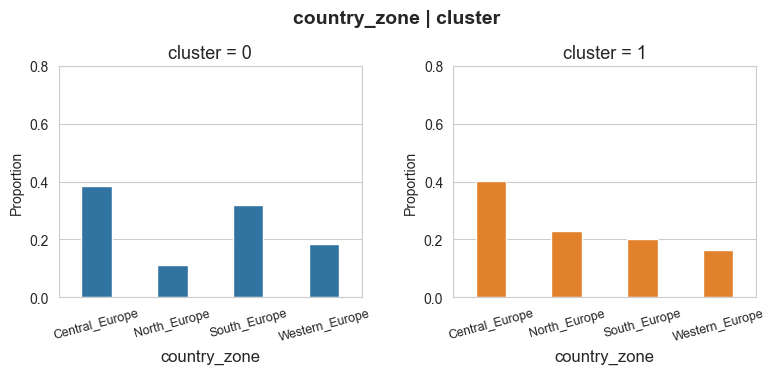

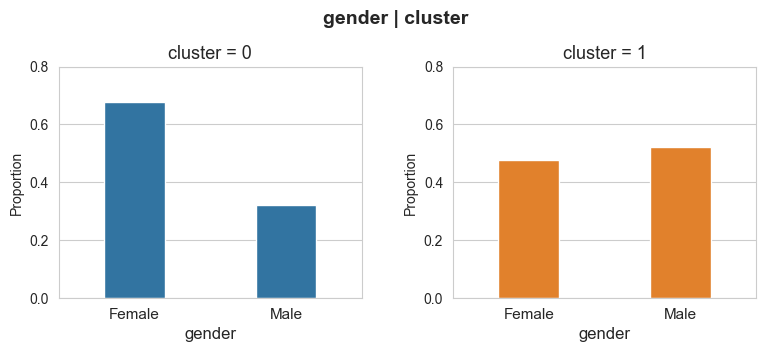

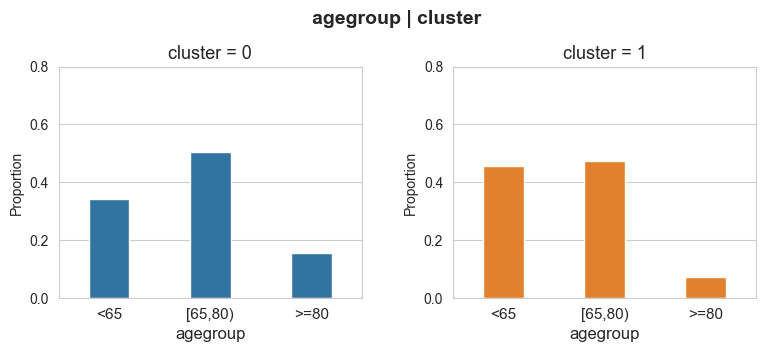

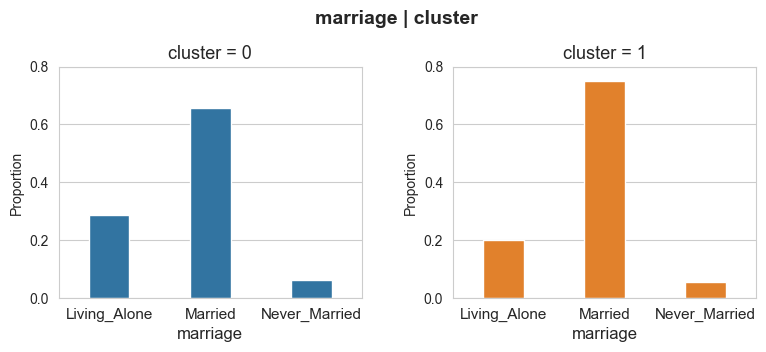

In [48]:
for col in [x for x in categorical_columns if x in no_wave_dependent_columns]:
    barplot_2D(df=clustering_df[2015][2], cat_conditioned=col, cat_condition='cluster', n_rows=1, 
               figsize=figsize[col], title_size=title_size[col], subtitles_size=subtitles_size[col], 
               title_height=title_height[col], ylabel_size=12,
               xlabel_size=xlabel_size[col], xticks_size=xticks_size[col], hspace=0.05, wspace=0.3, 
               palette='tab10', x_rotation=x_rotation[col],
               max_ytick=0.8, categories_order=categories_order[col], title= f'{col} | cluster',
               save=True, file_name=f'plots/clustering_interpretation_{col}')
# Same plots for all the waves, this is why only 2015 is used

In [24]:
stats[2015][2]['gender']

(gender | cluster) : unique values,abs_freq,rel_freq
object,i64,f64
"('Female', 0)",6441,0.6784
"('Male', 0)",3053,0.3216
"('Female', 1)",6112,0.4778
"('Male', 1)",6680,0.5222


In [25]:
stats[2015][2]['agegroup']

(agegroup | cluster) : unique values,abs_freq,rel_freq
object,i64,f64
"('>=80', 0)",1483,0.1562
"('[65,80)', 0)",4772,0.5026
"('<65', 0)",3239,0.3412
"('[65,80)', 1)",6066,0.4742
"('<65', 1)",5821,0.4551
"('>=80', 1)",905,0.0707


In [26]:
stats[2015][2]['marriage']

(marriage | cluster) : unique values,abs_freq,rel_freq
object,i64,f64
"('Living_Alone', 0)",2704,0.2848
"('Married', 0)",6222,0.6554
"('Never_Married', 0)",568,0.0598
"('Never_Married', 1)",678,0.053
"('Married', 1)",9586,0.7494
"('Living_Alone', 1)",2528,0.1976


In [27]:
stats[2015][2]['country_zone']

(country_zone | cluster) : unique values,abs_freq,rel_freq
object,i64,f64
"('Central_Europe', 0)",3647,0.3841
"('Western_Europe', 0)",1758,0.1852
"('North_Europe', 0)",1062,0.1119
"('South_Europe', 0)",3027,0.3188
"('Central_Europe', 1)",5135,0.4014
"('Western_Europe', 1)",2116,0.1654
"('North_Europe', 1)",2954,0.2309
"('South_Europe', 1)",2587,0.2022


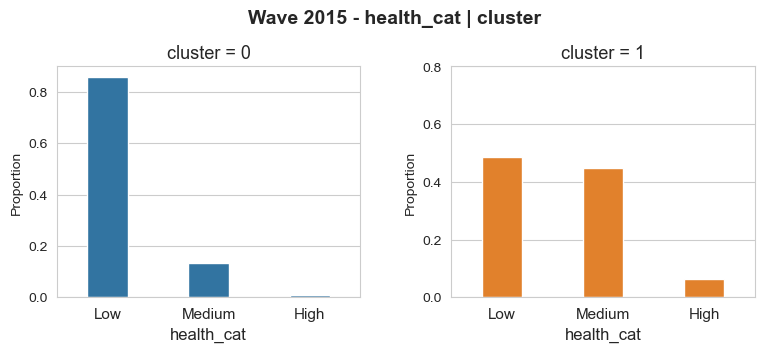

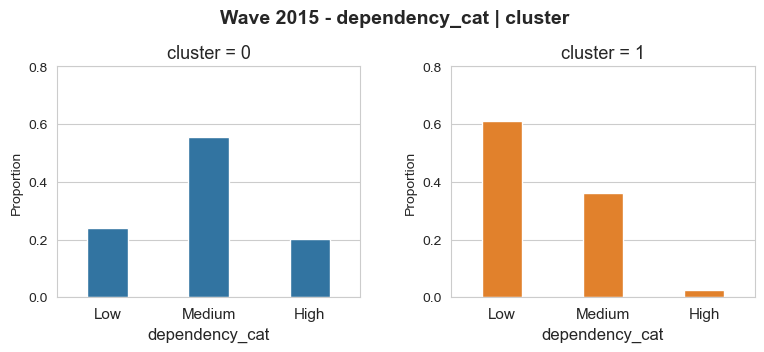

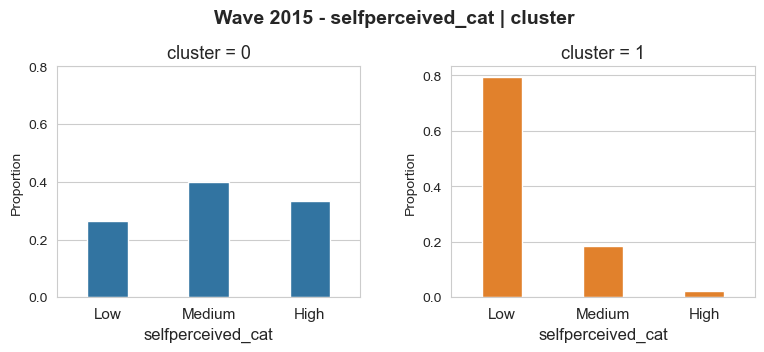

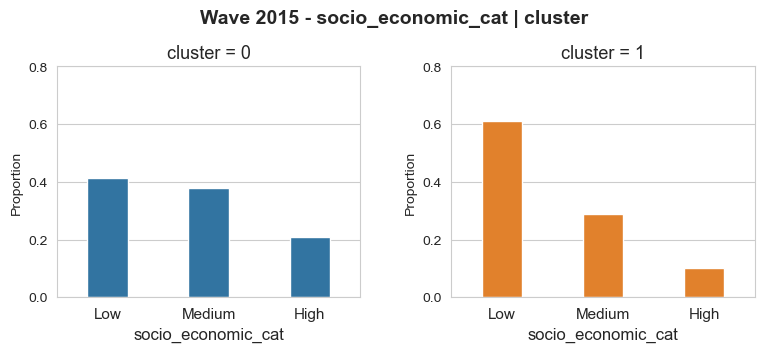

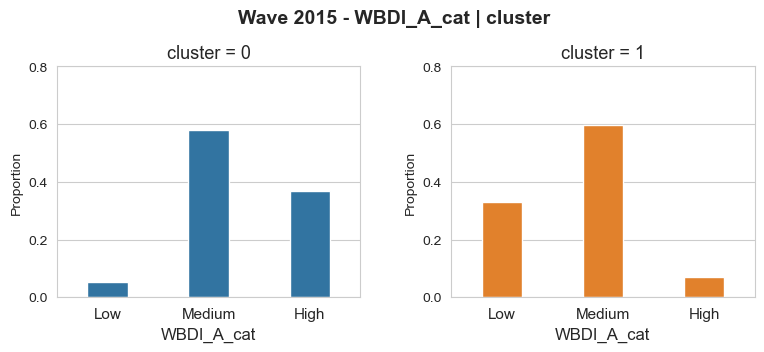

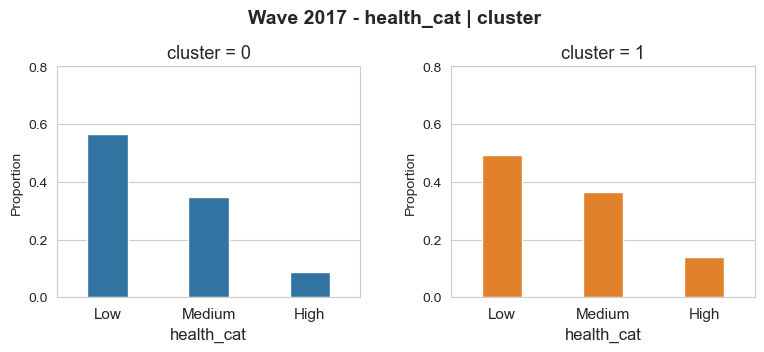

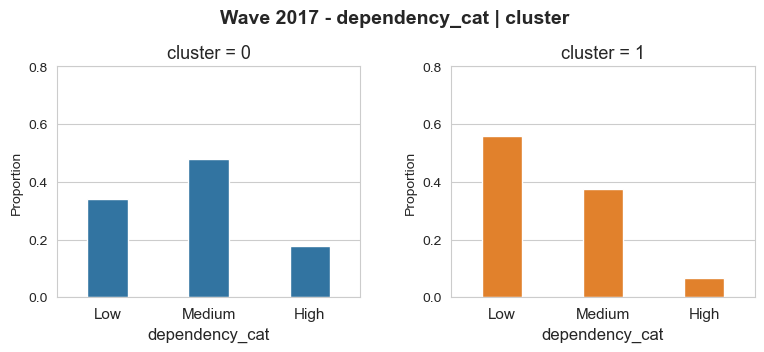

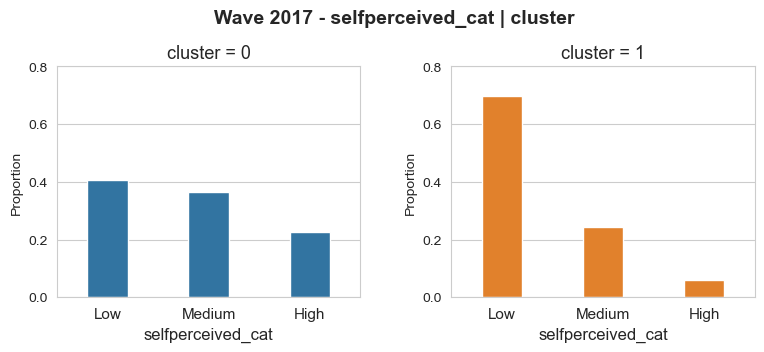

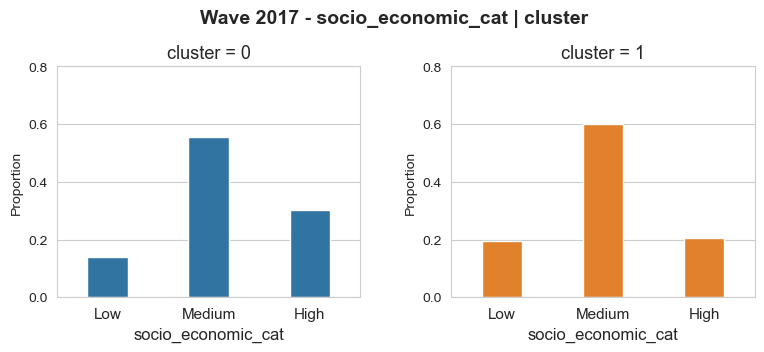

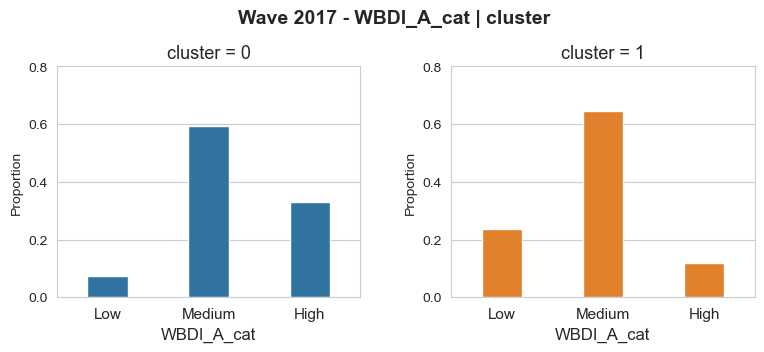

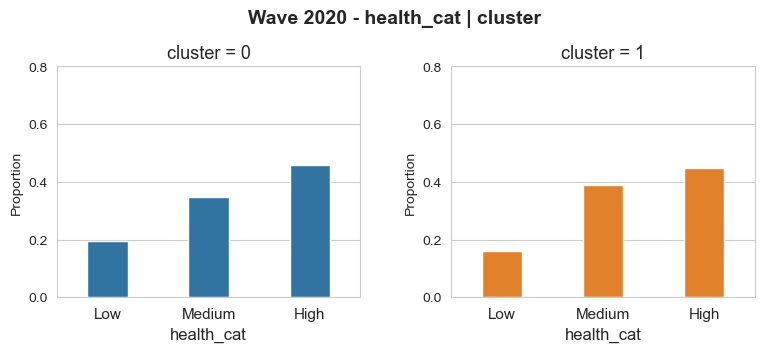

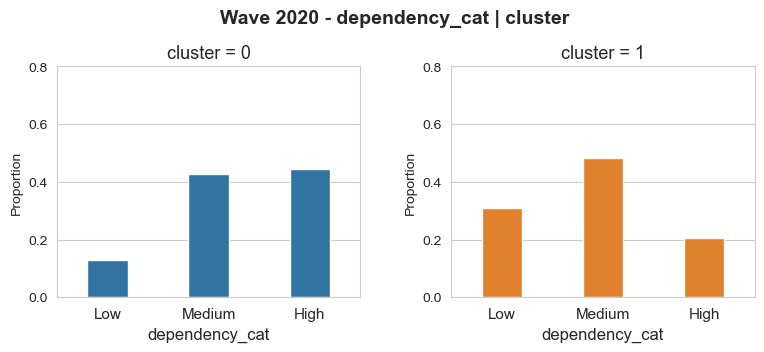

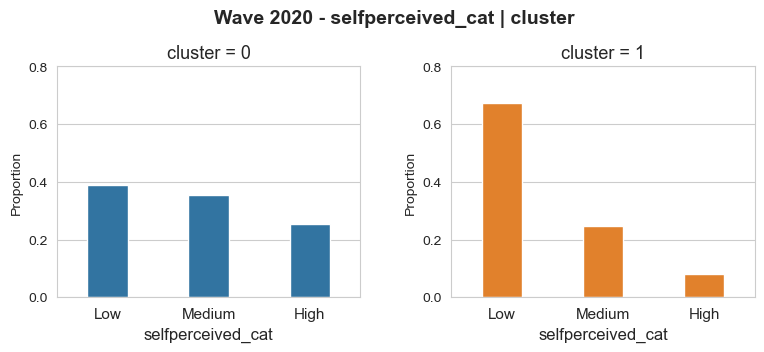

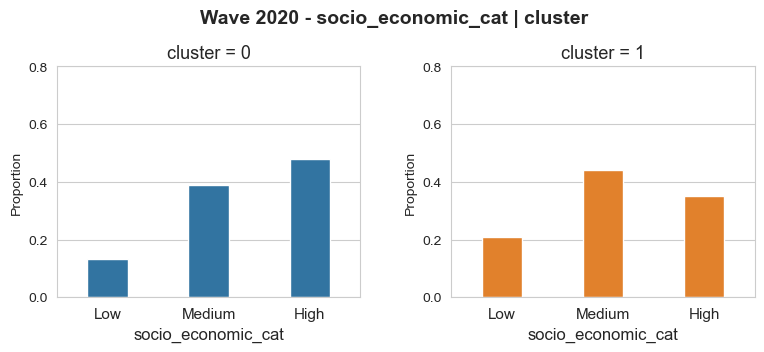

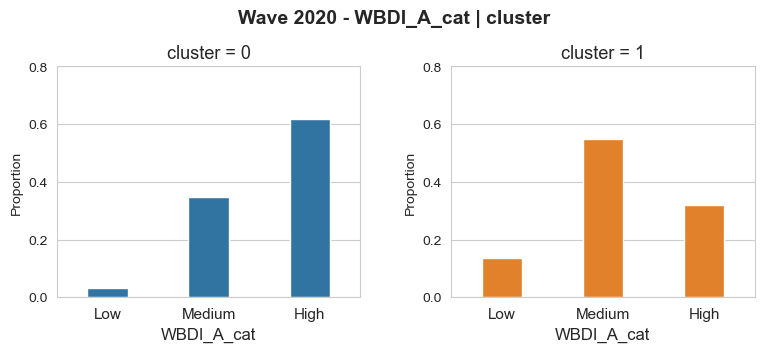

In [28]:
for wave in waves:
    for col in [x for x in categorical_columns if x not in no_wave_dependent_columns]:
        barplot_2D(df=clustering_df[wave][2], cat_conditioned=col, cat_condition='cluster', n_rows=1, 
                   figsize=figsize[col], title_size=14, subtitles_size=13, title_height=1.07, ylabel_size=12,
                   xlabel_size=12, xticks_size=11, hspace=0.05, wspace=0.3, palette='tab10', x_rotation=0,
                   max_ytick=0.8, categories_order=categories_order[col], title=f'Wave {wave} - {col} | cluster',
                   save=True, file_name=f'plots/clustering_interpretation_{col}_{wave}')

In [29]:
stats[2020][2]['WBDI_A_cat']

(WBDI_A_cat | cluster) : unique values,abs_freq,rel_freq
object,i64,f64
"('High', 0)",5868,0.6181
"('Medium', 0)",3304,0.348
"('Low', 0)",322,0.0339
"('High', 1)",4077,0.3187
"('Medium', 1)",6993,0.5467
"('Low', 1)",1722,0.1346


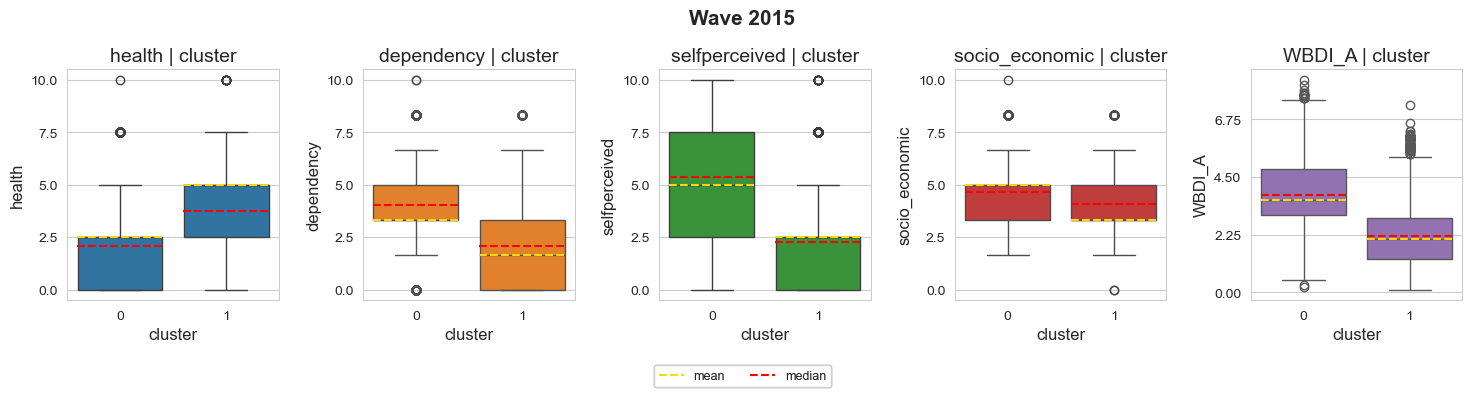

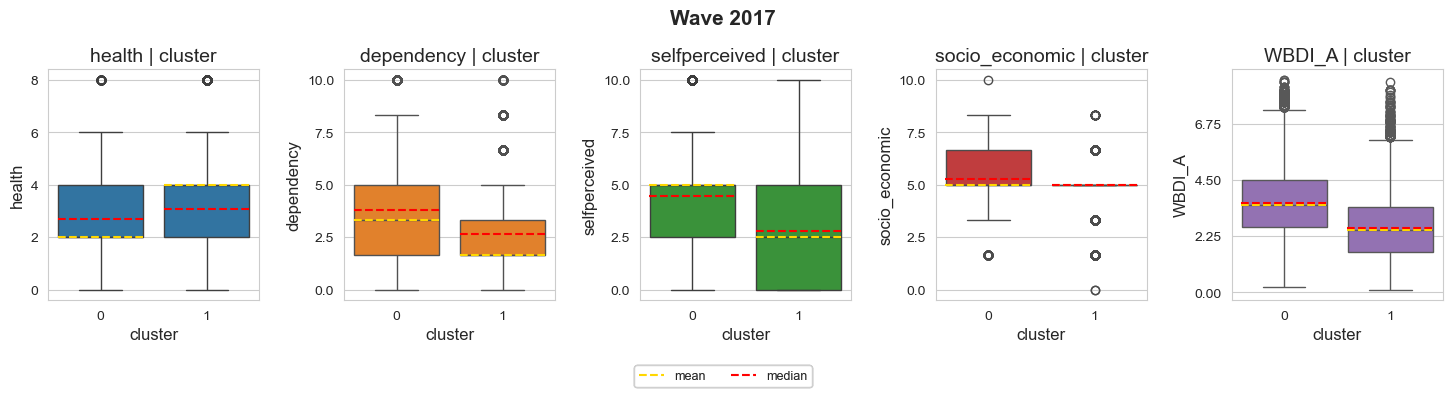

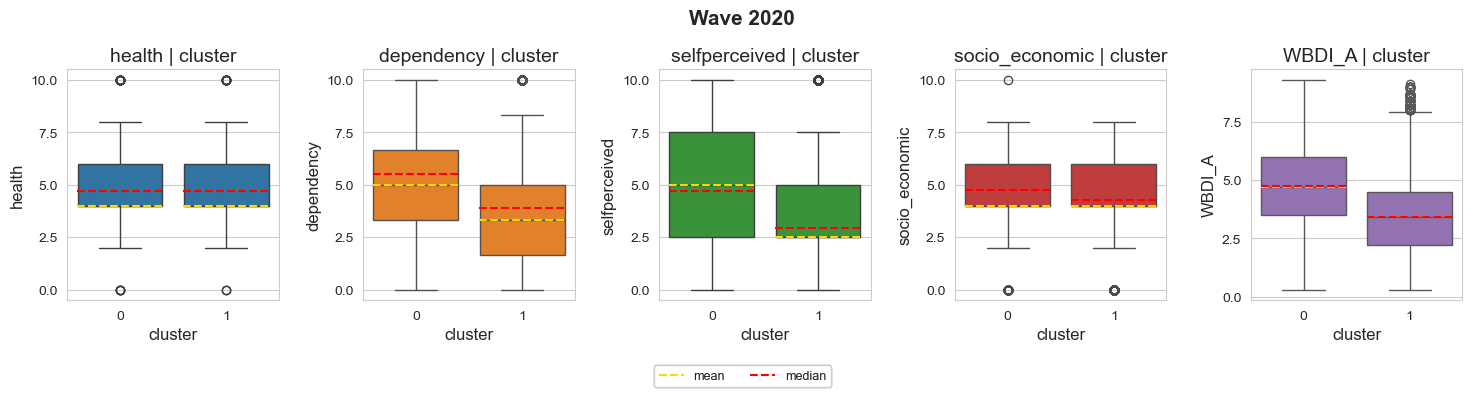

In [30]:
for wave in waves:
    boxplot_2D_matrix(df=clustering_df[wave][2], n_cols=5, title=f'Wave {wave}', figsize=(18,3), 
                        cat_col_names=['cluster'], quant_col_names=quant_columns,
                        n_yticks=5, title_height=1.08, title_fontsize=15, subtitles_fontsize=14,
                        statistics=['mean', 'median'], lines_width=0.81, bbox_to_anchor=(0.5, -0.2), 
                        legend_size=9, color_stats=['red', 'gold'], showfliers=True,
                        hspace=0.5, wspace=0.4, x_rotation=0, xlabel_size=12, ylabel_size=12,
                        save=True, file_name=f'plots/clustering_interpretation_quant_{wave}')